In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
from particles import resampling as rs
import importlib
import sys
sys.path.append('..')

import GaussianODEs as ode
import GaussianAlgorithms as algo
importlib.reload(ode)
importlib.reload(algo)

<module 'GaussianAlgorithms' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Gaussian/GaussianAlgorithms.py'>

In [2]:
mu = 20
sigma = 0.1
mu0 = 0
sigma0 = 1

In [3]:
Niter = 400
N = 500
X0 = np.random.normal(0, 1, size = N)

In [4]:
gammas = np.linspace(0.000, 0.1, 11)
gammas = gammas[1:]
gammas = np.insert(gammas, 0, 0.001)
X_tsmc = np.zeros((gammas.size, Niter+1, N))
W_tsmc = np.zeros((gammas.size, Niter+1, N))

X_twfr = np.zeros((gammas.size, Niter+1, N))
W_twfr = np.zeros((gammas.size, Niter+1, N))

mean_eq_twfr = np.zeros((gammas.size, Niter+1))
var_eq_twfr = np.zeros((gammas.size, Niter+1))
kl_eq_twfr = np.zeros((gammas.size, Niter+1))

In [5]:
gammas

array([0.001, 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.09 , 0.1  ])

In [8]:
for j in range(gammas.size):
    gamma = gammas[j]
    lseq_linear = np.arange(Niter+1)/Niter
    delta_linear = (gamma+np.exp(-gamma)-1)/gamma
    mean_eq_twfr[j], var_eq_twfr[j], kl_eq_twfr[j] = ode.tempered_wfr_infinite_time(mu0, mu, sigma0, sigma,  Niter, gamma, lseq_linear)
    X_tsmc[j, 0, :] = X0
    W_tsmc[j, 0, :] = np.ones(N)/N
    X_twfr[j, 0, :] = X0
    W_twfr[j, 0, :] = np.ones(N)/N
    for i in range(1, Niter+1):
        l = lseq_linear[i]
        noise = np.random.normal(0, 1, size = N)
        # T-SMC
        if(i > 1):
            # resample
            ancestors = rs.resampling('stratified', W_tsmc[j, i-1, :])
            X_tsmc[j, i-1, :] = X_tsmc[j, i-1, ancestors]
        X_tsmc[j, i, :], _ = algo.tempered_W_move(mu, sigma, X_tsmc[j, i-1, :], gamma, noise, l)
        W_tsmc[j, i, :] = algo.SMC_reweigthing(mu, sigma, X_tsmc[j, i,:], l-lseq_linear[i-1])
        # T-WFR
        if(i > 1):
            # resample
            ancestors = rs.resampling('stratified', W_twfr[j, i-1, :])
            X_twfr[j, i-1, :] = X_twfr[j, i-1, ancestors]
        X_twfr[j, i, :], gradient_step_twfr = algo.tempered_W_move(mu, sigma, X_twfr[j, i-1, :], gamma, noise, l)
        W_twfr[j, i, :] = algo.FR_reweigthing(mu, sigma, X_twfr[j, i, :], gamma, delta_linear, gradient_step_twfr)

In [9]:
mean_twfr = np.zeros((gammas.size, Niter+1))
var_twfr = np.zeros((gammas.size, Niter+1))
kl_twfr = np.zeros((gammas.size, Niter+1))

mean_tsmc = np.zeros((gammas.size, Niter+1))
var_tsmc = np.zeros((gammas.size, Niter+1))
kl_tsmc = np.zeros((gammas.size, Niter+1))
for j in range(gammas.size):
    for i in range(Niter+1):
        mean_twfr[j, i] = np.sum(X_twfr[j, i, :]*W_twfr[j, i, :])
        var_twfr[j, i] = np.sum(X_twfr[j, i, :]**2*W_twfr[j, i, :]) - mean_twfr[j, i]**2
        mean_tsmc[j, i] = np.sum(X_tsmc[j, i, :]*W_tsmc[j, i, :])
        var_tsmc[j, i] = np.sum(X_tsmc[j, i, :]**2*W_tsmc[j, i, :]) - mean_tsmc[j, i]**2
        kl_twfr[j, i] = ode.KL(mean_twfr[j, i], var_twfr[j, i], mu, sigma)
        kl_tsmc[j, i] = ode.KL(mean_tsmc[j, i], var_tsmc[j, i], mu, sigma)

In [10]:
kl_twfr[:, 0], kl_tsmc[:, 0], kl_eq_twfr[:, 0]

(array([2001.4452541, 2001.4452541, 2001.4452541, 2001.4452541,
        2001.4452541, 2001.4452541, 2001.4452541, 2001.4452541,
        2001.4452541, 2001.4452541, 2001.4452541]),
 array([2001.4452541, 2001.4452541, 2001.4452541, 2001.4452541,
        2001.4452541, 2001.4452541, 2001.4452541, 2001.4452541,
        2001.4452541, 2001.4452541, 2001.4452541]),
 array([2003.34870745, 2003.34870745, 2003.34870745, 2003.34870745,
        2003.34870745, 2003.34870745, 2003.34870745, 2003.34870745,
        2003.34870745, 2003.34870745, 2003.34870745]))

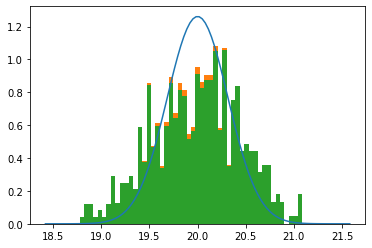

In [11]:
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))
plt.hist(X_twfr[-1, -1, :], density = True, weights = W_twfr[-1, -1, :], bins = 50);
plt.hist(X_tsmc[-1, -1, :], density = True, weights = W_tsmc[-1, -1, :], bins = 50);

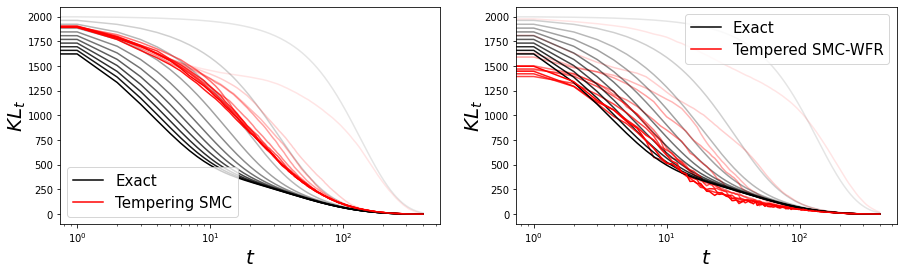

In [12]:
alphas = np.linspace(0.1, 1, gammas.size)

plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
for j in range(gammas.size):
    if(j == gammas.size-1):
        plt.plot(kl_eq_twfr[j, :], c = 'black', alpha = alphas[j], label = 'Exact');
        plt.plot(kl_tsmc[j, :], c = 'red', alpha = alphas[j], label = 'Tempering SMC');
    else:
        plt.semilogx(kl_eq_twfr[j, :], c = 'black', alpha = alphas[j]);
        plt.plot(kl_tsmc[j, :], c = 'red', alpha = alphas[j]);
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$KL_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 15)
plt.subplot(1, 2, 2)
for j in range(gammas.size):
    if(j == gammas.size-1):
        plt.semilogx(kl_eq_twfr[j, :], c = 'black', alpha = alphas[j], label = 'Exact');
        plt.plot(kl_twfr[j, :], c = 'red', alpha = alphas[j], label = 'Tempered SMC-WFR');
    else:
        plt.plot(kl_eq_twfr[j, :], c = 'black', alpha = alphas[j]);
        plt.plot(kl_twfr[j, :], c = 'red', alpha = alphas[j]); 
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$KL_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 15)
# plt.savefig('gaussian_tempered_fr_smc.pdf', bbox_inches="tight")

In [13]:
diff_smc = kl_eq_twfr - kl_tsmc
diff_twfr = kl_eq_twfr - kl_twfr

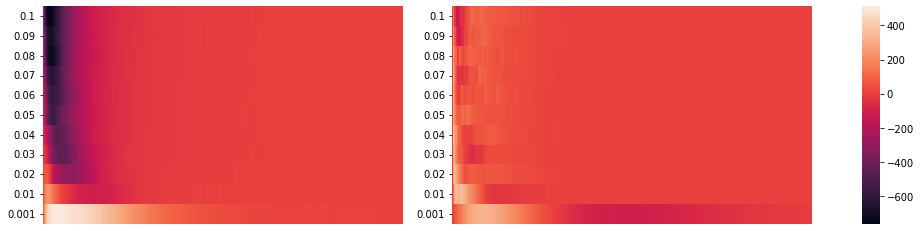

In [14]:
import seaborn as sns

f,(ax1,ax2, axcb) = plt.subplots(1,3, 
        gridspec_kw={'width_ratios':[2,2,0.1]},
                                figsize=(15, 4))

vmin = np.minimum(np.min(diff_smc), np.min(diff_twfr))
vmax = np.maximum(np.max(diff_smc), np.max(diff_twfr))
g1 = sns.heatmap(np.flip(diff_smc, axis = 0), vmin=vmin, vmax=vmax, cbar=False, ax=ax1, yticklabels = np.flip(gammas), xticklabels = False)
g2 = sns.heatmap(np.flip(diff_twfr, axis = 0), vmin=vmin, vmax=vmax, cbar_ax=axcb, ax=ax2, yticklabels = np.flip(gammas), xticklabels = False)